In [1]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph,START,END
from IPython.display import Image, display
from langchain_groq import ChatGroq

import os
from dotenv import load_dotenv
load_dotenv()
# Set environment variables for LangSmith tracking and LangChain project
os.environ["LANGCHAIN_API_KEY"] = os.getenv("LANGCHAIN_API_KEY")
os.environ["LANGCHAIN_PROJECT"] = os.getenv("LANGRAPH_LANGCHAIN_PROJECT")
os.environ["LANGCHAIN_TRACING_V2"] = "true"

# groq api
groq_api_key = os.getenv("GROQ_API_KEY")
llm=ChatGroq(groq_api_key=groq_api_key,model_name="llama-3.1-8b-instant")

d:\study\udemy\langchain\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
## reducers
from typing import Annotated
from langgraph.graph.message import add_messages

In [3]:
## Langgraph Application ###

#  Messages have the type 'list'. Annotated is used to add metadata i.e which is human message and which is AI message.
# The 'add_messages function in the annotation defines how this state key should be updated (in this case, it appends messags to the list,rather than overwriting them).
# messages variable is of type Annotated
# State class inheriting TypedDict. For key value pair representation.

class State(TypedDict): 
  messages:Annotated[list,add_messages] 

In [4]:
# chatbot takes parameter as state. Chatbot is inheriting State class because state management keeps on changing.
# chatbot function is invoking previous messages given by user with state and creating new messages which is returned.
def chatbot(state:State):
  return {"messages":[llm.invoke(state["messages"])]}

In [6]:
from langgraph.checkpoint.memory import MemorySaver
memory = MemorySaver()

#starting graph building process
graph = StateGraph(State)

#node
graph.add_node("chatbot",chatbot)
#edges
graph.add_edge(START,"chatbot")
graph.add_edge("chatbot",END)

graph_builder = graph.compile()
graph_memory = graph.compile(checkpointer=memory)

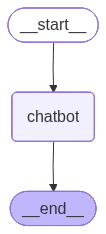

In [7]:
from IPython.display import display, Image
## visualize graph as mermaid diagram
display(Image(graph_builder.get_graph().draw_mermaid_png()))

In [ ]:
# streaming -> methods - stream - sync, astream - async 
# parameters - values, updates

# streaming the responses # full conversation is updated and displayed with each response
config = {"configurable":{"thread_id":"1"}}
while True:
   user_input = input("User: ")
   if user_input.lower() in ["quit","q"]:
      print("Good Bye!")
      break
   for event in graph_builder.stream({'messages':("user",user_input)},stream_mode='values'):
      print(event)
      for value in event.values():
         print(value['messages']) # it should user message
         print("Assistant:", value['messages'][-1].content) # it should have llm model response

{'messages': [HumanMessage(content='what is nuts', additional_kwargs={}, response_metadata={}, id='5b6eb8f6-ee67-4bc7-b2e7-fd2ee3d5ccb4')]}
{'messages': [HumanMessage(content='what is nuts', additional_kwargs={}, response_metadata={}, id='5b6eb8f6-ee67-4bc7-b2e7-fd2ee3d5ccb4'), AIMessage(content="Nuts are the edible seeds of plants, typically from trees or shrubs. They are a type of fruit, specifically a type of dry fruit that doesn't open to release its seeds when ripe. Nuts are a good source of protein, fiber, and healthy fats, making them a popular snack and ingredient in many cuisines.\n\nTypes of nuts include:\n\n1. Tree nuts:\n\t* Almonds\n\t* Walnuts\n\t* Pecans\n\t* Hazelnuts\n\t* Cashews\n\t* Pistachios\n\t* Brazil nuts\n2. Seed nuts:\n\t* Peanuts (technically a legume, but often referred to as a nut)\n\t* Pumpkin seeds\n\t* Sunflower seeds\n\nNuts have several characteristics that make them distinct from other seeds:\n\n1. Hard shell: Nuts have a hard, woody shell that protec

In [ ]:
# streaming the responses #updates recent message with each response and displays only the latest message
config = {"configurable":{"thread_id":"2"}}
while True:
   user_input = input("User: ")
   if user_input.lower() in ["quit","q"]:
      print("Good Bye!")
      break
   for event in graph_memory.stream({'messages':("user",user_input)},config,stream_mode='updates'):
      print(event)
      for value in event.values():
         print(value['messages']) # it should print user message
         print("Assistant:", value['messages'][-1].content) # it should have llm model response

In [14]:
# we often want to stream more than grAPH STATE. in particular with chat model calls it is common to stream the tokens as they are generated. 
# we can do this using astream_events method
config = {"configurable":{"thread_id":"3"}}
while True:
   user_input = input("User: ")
   if user_input.lower() in ["quit","q"]:
      print("Good Bye!")
      break
   async for event in graph_memory.astream_events({'messages':("user",user_input)},config,version='v2'):
      print(event)
      #for value in event.values():
      #   print(value['messages']) # it should user message
      #   print("Assistant:", value['messages'][-1].content) # it should have llm model response

{'event': 'on_chain_start', 'data': {'input': {'messages': ('user', 'hi chatbot')}}, 'name': 'LangGraph', 'tags': [], 'run_id': '6c2e7174-78f3-4464-bc2f-bbc9295ba4e4', 'metadata': {'thread_id': '3'}, 'parent_ids': []}
{'event': 'on_chain_start', 'data': {'input': {'messages': [HumanMessage(content='hi chatbot', additional_kwargs={}, response_metadata={}, id='41b7f8e3-3b18-4191-823b-a42731f791aa'), AIMessage(content='How can I help you today?', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 8, 'prompt_tokens': 38, 'total_tokens': 46, 'completion_time': 0.013411805, 'prompt_time': 0.001660218, 'queue_time': 0.048211952, 'total_time': 0.015072023}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_ab04adca7d', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--bfdab10e-885a-404f-9d3a-88f0e8e7394f-0', usage_metadata={'input_tokens': 38, 'output_tokens': 8, 'total_tokens': 46}), HumanMessage(content='hi chatbot', ad